In [1]:
! pip install numba
import numba
from numba import cuda
from numba.cuda.cudadrv import enums
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from numba import vectorize

In [48]:
params = {
    'figure.figsize': [15, 10],  # instead of 4.5, 4.5
    'axes.titlesize': 15,
    'axes.labelsize': 10,
    'axes.linewidth': 0.5,
    'font.size': 20,
    'font.family': 'monospace',
    #    'font.monospace': 'Alma Mono',
    'legend.fontsize': 15,
    'legend.loc': 'upper right',
    'legend.labelspacing': 0.25,
    # 'xtick.labelsize': 20,
    # 'ytick.labelsize': 20,
    'lines.linewidth': 3,
    'text.usetex': False,
    # 'figure.autolayout': True,
    'ytick.right': False,
    'xtick.top': False,

    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,

    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,

    'xtick.major.pad': 2,
    'ytick.major.pad': 2,
    # 'xtick.minor.pad': 14,
    # 'ytick.minor.pad': 14,

    'xtick.direction': 'inout',
    'ytick.direction': 'inout',

    'grid.linestyle': '-',         # solid
    'grid.linewidth': 1.5,        # in points
    'grid.alpha':     1,        # transparency, between 0.0 and 1.0
}
# plt.style.use('fivethirtyeight')
matplotlib.rcParams.update(params)

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# Get the device name and number of devices
print("Detecting available device",cuda.detect())
print("Device found:",cuda.devices)
print(cuda.gpus)
device = cuda.select_device(0)

# Print all the attribute
#attribs= [name.replace("CU_DEVICE_ATTRIBUTE_", "") for name in dir(enums) if name.startswith("CU_DEVICE_ATTRIBUTE_")]
#for attr in attribs:
#    print(attr, '=', getattr(device, attr))


Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-00cc83cc-6fb8-b75b-e34b-c700c66a809d
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
Detecting available device True
Device found: <module 'numba.cuda.cudadrv.devices' from '/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devices.py'>
<Managed Device 0>


In [54]:
#LABWORK6 - 2D KERNEL

Data_path="/content/drive/MyDrive/HPC/"
Image_path=Data_path+"Test_org.jpg"
Image_path=Data_path+"Test_org_2.jpg"
# blockDim.x,y,z gives the number of threads in a block, in the particular direction
# gridDim.x,y,z gives the number of blocks in a grid, in the particular direction
# blockDim.x * gridDim.x gives the number of threads in a grid


# Mapping
@cuda.jit
def grayscale(src, dst, threshold):
  print("test")
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  g = np.uint8(src[tidx,tidy, 0] + src[tidx,tidy, 1] + src[tidx,tidy, 2]) / 3
  print(g)
  print(threshold)
  if g >= threshold:
    g = 1
  else:
    g = 0
  dst[tidx,tidy, 0] = dst[tidx,tidy, 1] = dst[tidx,tidy, 2] = g

@cuda.jit
def brightness(src, dst, scale):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  for i in range(3):
    dst[tidx,tidy,i] = src[tidx,tidy,i] + scale

@cuda.jit
def Mapping_2(src,dst,weight,src_2):
  def blend(weight):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    c = weight
    if c <= 1:
      raise KeyError("Please check you input again")
    else:
      for i in range(3):
        dst[tidx, tidy, i] = src[tidx, tidy, i] * c + src_2[tidx, tidy, i] * (1 - c)

# Image data
img_data=plt.imread(Image_path)

# Shape of the figure
(imageHeight,imageWidth,_)=img_data.shape
pixelCount = imageWidth * imageHeight
out_img = np.array(img_data, copy=True)


def compare(blockSize, function, threshold = 100, scale = 5, weight = 0.5, output=False, Image_path_2 = False):
  #Grid size -> chunk
  #int to ensure it's an interger
  # BlockSize should be the multiplication of 32
  grid_1 = int(imageHeight/blockSize)
  grid_2 = int(imageWidth/blockSize)
  print(grid_1,grid_2)
  gridSize=(grid_1,grid_2)

  blockSize=(blockSize,blockSize)

  # Start timing
  start_time=time.time()

  # Copy image to the device from host(CPU)
  devSrc = cuda.to_device(img_data)


  # Allocate memory on the device (GPU)
  devDst = cuda.device_array((imageHeight,imageWidth,3), np.uint8)

  if Image_path_2 is False:
    if function == 1:
      grayscale[gridSize,blockSize](devSrc, devDst, threshold)
    else:
      brightness[gridSize,blockSize](devSrc, devDst, scale)
  else:
    function = 3
    # Image data
    img_data_2=plt.imread(Image_path_2)

    # Shape of the figure
    (imageHeight_2,imageWidth_2,_)=img_data_2.shape
    pixelCount = imageWidth_2 * imageHeight_2
    grid_1 = int(imageHeight_2/blockSize)
    grid_2 = int(imageWidth_2/blockSize)
    print(grid_1,grid_2)
    gridSize_2=(grid_1,grid_2)
    devSrc_2 = cuda.to_device(img_data_2)

    Mapping_2[gridSize,blockSize](devSrc, devDst, function, threshold, scale, weight, devSrc_2)


  #Copy from device to host
  hostDst = devDst.copy_to_host()

  # Stop timing
  end_time=time.time()

  #Get the running time
  run_time=end_time-start_time

  if output == True:
    return run_time, hostDst
  else: return run_time

1
67 120
(1082, 1920, 3)
(1082, 1920, 3)
The run time is 0.006941080093383789 s
1082 1920
The runtime for the blockSize 1 is 0.012190580368041992
541 960
The runtime for the blockSize 2 is 0.00648188591003418
270 480
The runtime for the blockSize 4 is 0.0057528018951416016
135 240
The runtime for the blockSize 8 is 0.005609035491943359
67 120
The runtime for the blockSize 16 is 0.0060122013092041016


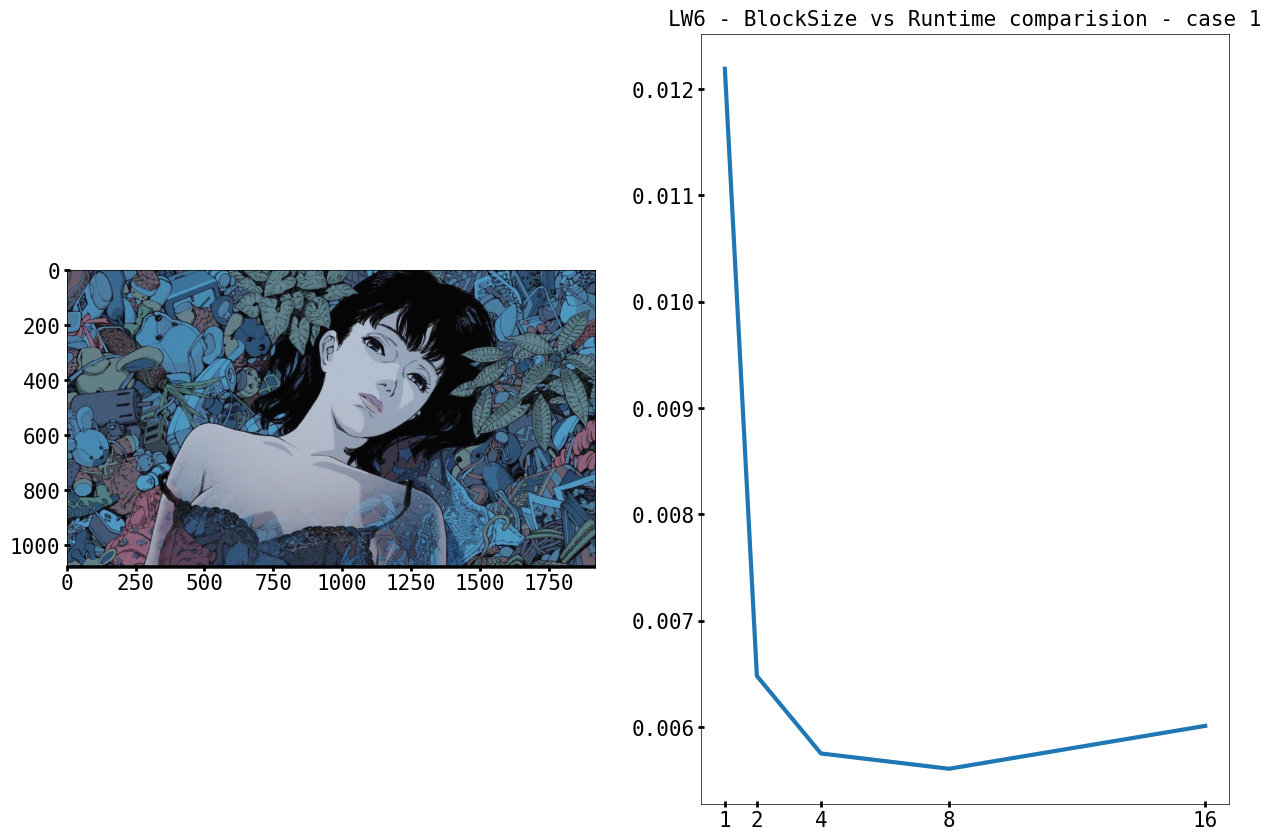

In [58]:
#Output run_time and hostDst
function = input()

plt.subplot(1,2,1)
#Individual case
blockSize = 16
run_time,hostDst = compare(blockSize, function, output=True)

# Show the resule image
print(img_data.shape)
print(hostDst.shape)
plt.imshow(hostDst)
# Save the image
plt.savefig(f'{Data_path}Test_result_LW6_case_{function}.jpg')
print("The run time is",run_time,"s")

plt.subplot(1,2,2)
#Comparision case
runtime_list=[]
blockSize_final=[]
blockSize_label=[]
for i in range(0,5):
  blockSize=2**i
  run_time=compare(blockSize,function, output = False)
  runtime_list.append(run_time)
  blockSize_final.append(blockSize)
  blockSize_label.append(str(blockSize))
  print(f"The runtime for the blockSize {blockSize} is {run_time}")

name=f'LW6 - BlockSize vs Runtime comparision - case {function}' # - Shared memory')
plt.plot(blockSize_final,runtime_list)
plt.xticks(blockSize_final,blockSize_label)
plt.title(name) #- Shared memory")
plt.savefig(Data_path + name + ",png")

In [34]:
#LABWORK5 - Gaussain filter

Data_path="/content/drive/MyDrive/HPC/"
Image_path=Data_path+"Test_org.jpg"

# blockDim.x,y,z gives the number of threads in a block, in the particular direction
# gridDim.x,y,z gives the number of blocks in a grid, in the particular direction
# blockDim.x * gridDim.x gives the number of threads in a grid

@cuda.jit
def convolution(src,dst,filter,shared = False):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if shared == True:
  #Define size of running matrix
    filter_h,filter_w, = filter.shape
  else:
    # Define running matrix
    filter_h,filter_w = 7, 7
    #Shared memory
    copy_shared=cuda.shared.array(shape=(filter_h,filter_w),dtype=np.float32)
    if cuda.threadIdx.x < filter_h and cuda.threadIdx.y < filter_w:
      copy_shared[cuda.threadIdx.x, cuda.threadIdx.y] = filter[cuda.threadIdx.x, cuda.threadIdx.y]
    cuda.syncthreads()
    #cuda.syncthreads()


  for i in range(3):
    tmp_data=0
    for m in range(-(filter_h//2),(filter_h//2+1)):
      for n in range(-(filter_w//2),(filter_w//2+1)):
        if tidx + m >=0 and tidy + n >=0 and tidx + m < int(imageHeight) and tidy + n < int(imageWidth):
          if shared == False:
            tmp_data += np.float32(src[int(tidx+m),int(tidy+n),i]) * filter[m+filter_h //2, n+filter_w //2]
          else:
            tmp_data += np.float32(src[int(tidx+m),int(tidy+n),i]) * copy_shared[m+filter_h //2, n+filter_w //2]
    dst[tidx,tidy,i]=tmp_data



# Image data
img_data=plt.imread(Image_path)

# Shape of the figure
(imageHeight,imageWidth,_)=img_data.shape
pixelCount = imageWidth * imageHeight

#Filter
Gaussian_filter=np.array([[0,0,1,2,1,0,0],[0,3,13,22,13,3,0],[1,13,59,97,59,133,1],[2,22,97,159,97,22,2] \
                            ,[1,13,59,97,59,13,1],[0,3,13,22,13,3,0],[0,0,1,2,1,0,0]],dtype=np.float32) / 1003

#Ouput image
gauss_img = np.array(img_data, copy=True)

def compare(blockSize,output=False,shared=False):
  #Grid size -> chunk
  #int to ensure it's an interger
  # BlockSize should be the multiplication of 32
  grid_1 = int(imageHeight/blockSize)
  grid_2 = int(imageWidth/blockSize)
  print(grid_1,grid_2)
  gridSize=(grid_1,grid_2)

  blockSize=(blockSize,blockSize)

  # Start timing
  start_time=time.time()

  # Copy image to the device from host(CPU)
  devSrc = cuda.to_device(img_data)

  # Allocate memory on the device (GPU)
  devDst = cuda.device_array((imageHeight,imageWidth,3), np.uint8)

  convolution[gridSize,blockSize](devSrc, devDst,Gaussian_filter,shared)
  cuda.synchronize()

  #Copy from device to host
  hostDst = devDst.copy_to_host()

  # Stop timing
  end_time=time.time()

  #Get the running time
  run_time=end_time-start_time

  if output == True:
    return run_time, hostDst
  else:
    return run_time

In [ ]:
output = False
#shared = True

300 480
The run time is 0.04037928581237793 s
1200 1920


/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


The runtime for the blockSize 1 is 0.360332727432251
600 960
The runtime for the blockSize 2 is 0.06287336349487305
300 480
The runtime for the blockSize 4 is 0.021111249923706055
150 240
The runtime for the blockSize 8 is 0.012724876403808594
75 120
The runtime for the blockSize 16 is 0.012616157531738281


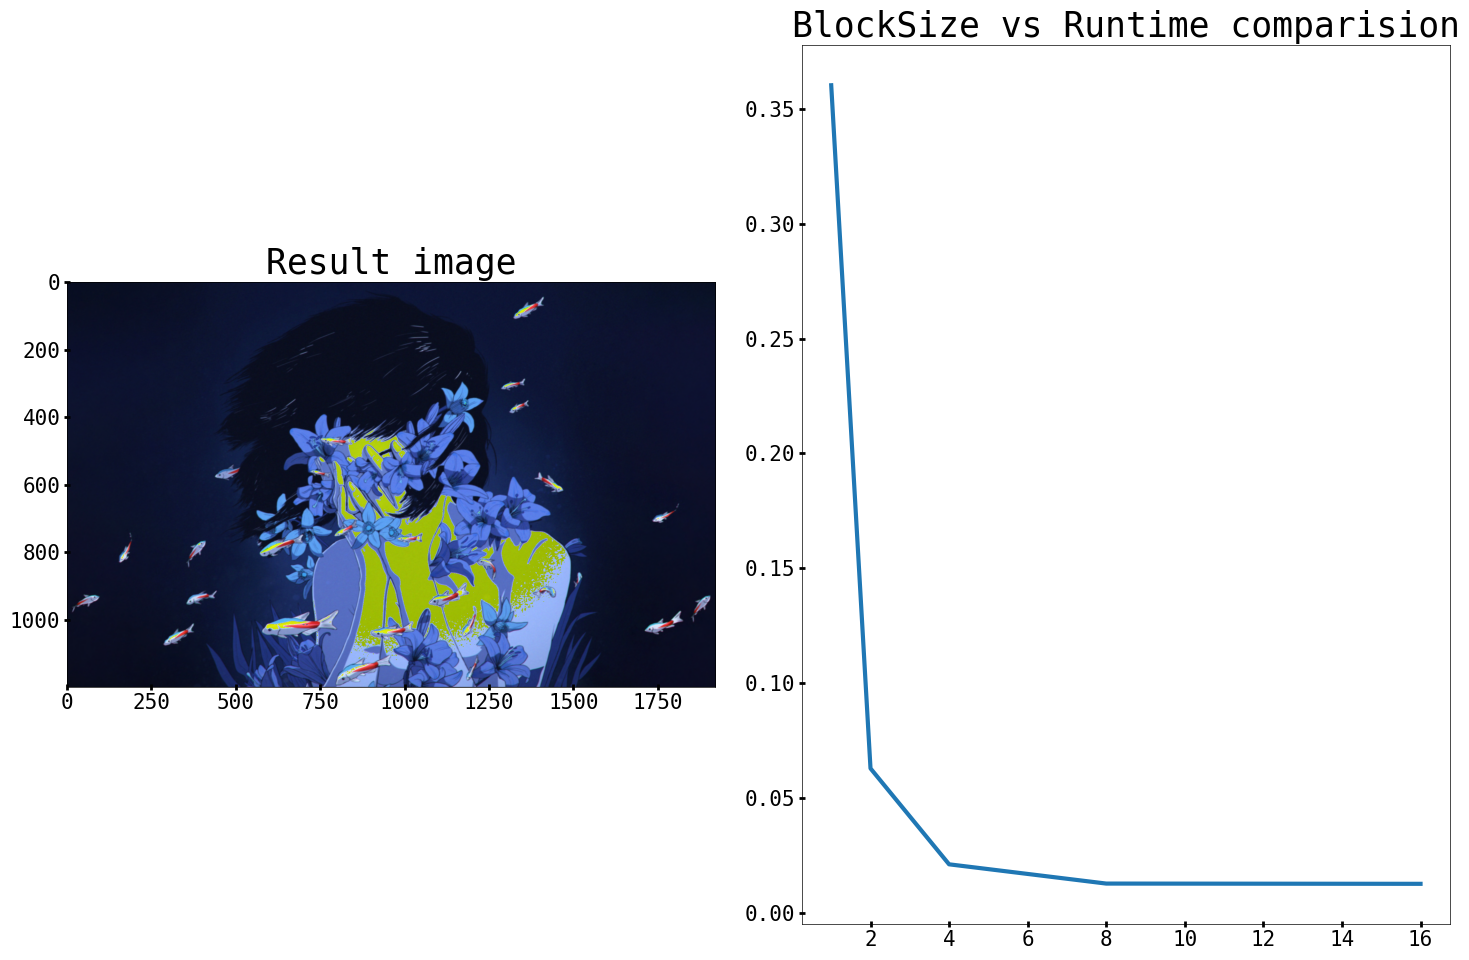

In [36]:
#Output run_time and hostDst

plt.subplot(1,2,1)
blockSize = 4
run_time,hostDst= compare(blockSize,output=True)

# Show the resule image
plt.title("Result image")
plt.imshow(hostDst)

# Save the image
plt.savefig(Data_path+"Test_result_LW5.jpg")
print("The run time is",run_time,"s")

plt.subplot(1,2,2)
### Comparision
runtime_list=[]
blockSize_final=[]
for i in range(5):
  blockSize=2**i
  run_time=compare(blockSize,output=False)
  runtime_list.append(run_time)
  blockSize_final.append(blockSize)
  print(f"The runtime for the blockSize {blockSize} is {run_time}")

  name=f'L5 - BlockSize vs Runtime comparision' # - Shared memory')
plt.plot(blockSize_final,runtime_list)
plt.title("BlockSize vs Runtime comparision") #- Shared memory")
plt.savefig(Data_path + name + ",png")


plt.tight_layout()
plt.show()

In [4]:
#LABWORK4 - 2D KERNEL

Data_path="/content/drive/MyDrive/HPC/"
Image_path=Data_path+"Test_org.jpg"

# blockDim.x,y,z gives the number of threads in a block, in the particular direction
# gridDim.x,y,z gives the number of blocks in a grid, in the particular direction
# blockDim.x * gridDim.x gives the number of threads in a grid

@cuda.jit
def grayscale(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  g = np.uint16(src[tidx,tidy, 0] + src[tidx,tidy, 1] + src[tidx,tidy, 2]) / 3
  dst[tidx,tidy, 0] = dst[tidx,tidy, 1] = dst[tidx,tidy, 2] = g


# Image data
img_data=plt.imread(Image_path)

# Shape of the figure
(imageHeight,imageWidth,_)=img_data.shape
pixelCount = imageWidth * imageHeight
gray_img = np.array(img_data, copy=True)

def compare(blockSize,output=False):
  #Grid size -> chunk
  #int to ensure it's an interger
  # BlockSize should be the multiplication of 32
  grid_1 = int(imageHeight/blockSize)
  grid_2 = int(imageWidth/blockSize)
  print(grid_1,grid_2)
  gridSize=(grid_1,grid_2)

  blockSize=(blockSize,blockSize)

  # Start timing
  start_time=time.time()

  # Copy image to the device from host(CPU)
  devSrc = cuda.to_device(img_data)

  # Allocate memory on the device (GPU)
  devDst = cuda.device_array((imageHeight,imageWidth,3), np.uint16)

  grayscale[gridSize,blockSize](devSrc, devDst)

  #Copy from device to host
  hostDst = devDst.copy_to_host()

  # Stop timing
  end_time=time.time()

  #Get the running time
  run_time=end_time-start_time

  if output == True:
    return run_time, hostDst
  else: return run_time

300 480
The run time is 0.010063648223876953 s
1200 1920
The runtime for the blockSize 1 is 0.027475595474243164
600 960
The runtime for the blockSize 2 is 0.012762784957885742
300 480
The runtime for the blockSize 4 is 0.013503551483154297
150 240
The runtime for the blockSize 8 is 0.008693695068359375
75 120
The runtime for the blockSize 16 is 0.0089111328125
37 60
The runtime for the blockSize 32 is 0.009706735610961914


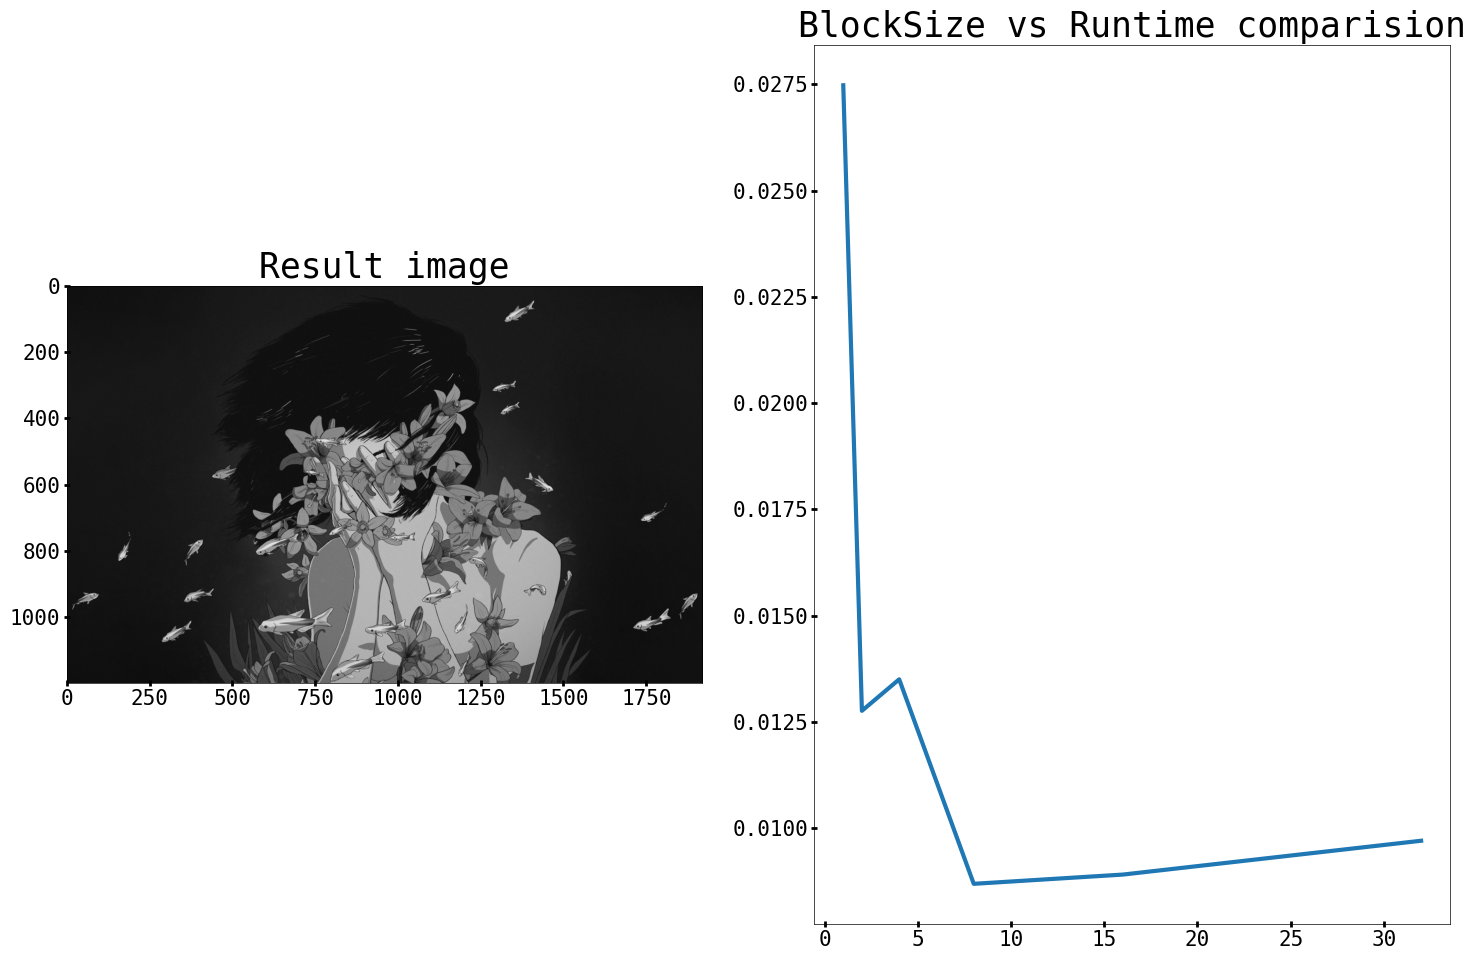

In [18]:
#Output run_time and hostDst

plt.subplot(1,2,1)
# output=False
blockSize = 4
run_time,hostDst= compare(blockSize,output=True)

# Show the resule image
plt.title("Result image")
plt.imshow(hostDst)

# Save the image
plt.savefig(Data_path+"Test_result_LW4.jpg")
print("The run time is",run_time,"s")

plt.subplot(1,2,2)
### Comparision
runtime_list=[]
blockSize_final=[]
for i in range(6):
  blockSize=2**i
  run_time=compare(blockSize,output=False)
  runtime_list.append(run_time)
  blockSize_final.append(blockSize)
  print(f"The runtime for the blockSize {blockSize} is {run_time}")

  name=f'LW4 - BlockSize vs Runtime comparision' # - Shared memory')
plt.plot(blockSize_final,runtime_list)
plt.title("BlockSize vs Runtime comparision") #- Shared memory")
plt.savefig(Data_path + name + ",png")


plt.tight_layout()
plt.show()

In [27]:
#LABWORK 3 - 1D KERNEL
Data_path="/content/drive/MyDrive/HPC/"
Image_path=Data_path+"Test_org.jpg"

# blockDim.x,y,z gives the number of threads in a block, in the particular direction
# gridDim.x,y,z gives the number of blocks in a grid, in the particular direction
# blockDim.x * gridDim.x gives the number of threads in a grid

#@vectorize(['float32(float32, float32)'], target='cuda')
@cuda.jit
def grayscale(src, dst):
# where are we in the input?
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  print(tidx)
  g = np.uint8((int(src[tidx, 0]) + int(src[tidx, 1]) + int(src[tidx, 2])) / 3)
  dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g


# Image data
img_data=plt.imread(Image_path)

# Shape of the figure
(imageHeight,imageWidth,_)=img_data.shape
pixelCount = imageWidth * imageHeight

def compare(blockSize,output=False):
  #Grid size -> chunk
  #int to ensure it's an interger
  gridSize = int(pixelCount / blockSize)

  # Flatten image into an array
  img_flatten=img_data.flatten().reshape((pixelCount,3))
  #print(img_flatten)


  # Start timing
  start_time=time.time()

  # Copy image to the device from host(CPU)
  devSrc = cuda.to_device(img_flatten)

  # Allocate memory on the device (GPU)
  devDst = cuda.device_array((pixelCount, 3), np.uint8)

  grayscale[gridSize,blockSize](devSrc, devDst)

  cuda.synchronize()

  #Copy from device to host
  hostDst = devDst.copy_to_host()

  # Stop timing
  end_time=time.time()

  #Get the running time
  run_time=end_time-start_time

  if output == True:
    return run_time, hostDst
  else: return run_time



The runtime for the blockSize 1 is 6.005939245223999
The runtime for the blockSize 2 is 5.404122352600098
The runtime for the blockSize 4 is 5.8347954750061035
The runtime for the blockSize 8 is 7.993768930435181
The runtime for the blockSize 16 is 17.702831506729126
The run time is 17.702831506729126 s


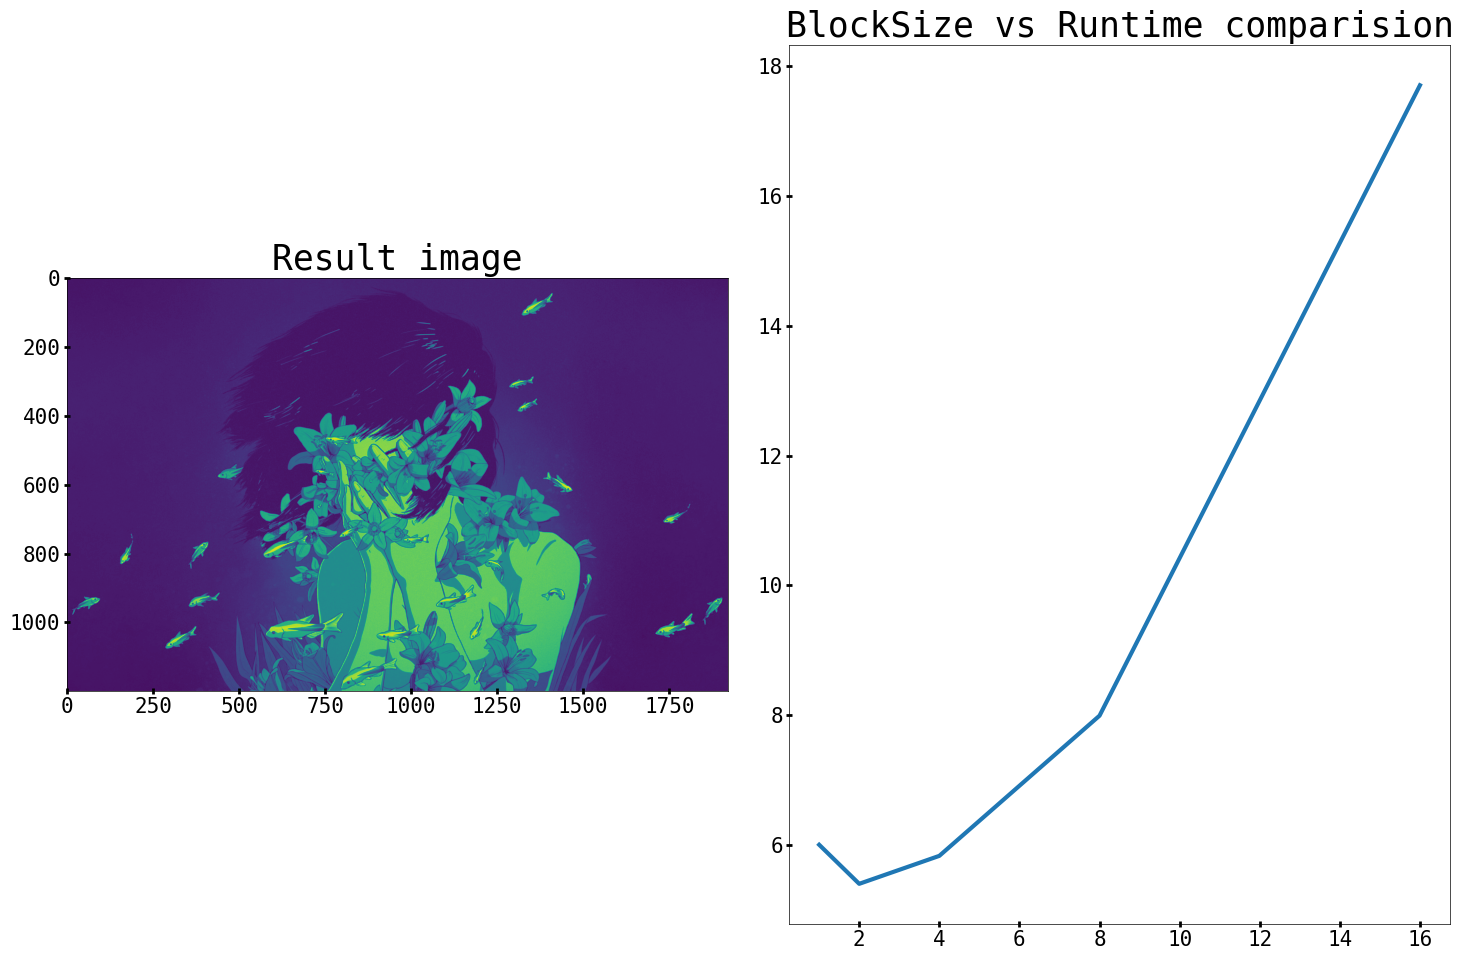

In [33]:
#Output run_time and hostDst

plt.subplot(1,2,1)
# output=False
blockSize = 16
run_time,hostDst= compare(blockSize,output=True)
res_image = np.reshape(hostDst, (imageHeight, imageWidth, 3))[:, :, 0]

# Show the resule image
plt.title("Result image")
plt.imshow(res_image)

plt.subplot(1,2,2)
### Comparision
runtime_list=[]
blockSize_final=[]
for i in range(5):
  blockSize=2**i
  run_time=compare(blockSize,output=False)
  runtime_list.append(run_time)
  blockSize_final.append(blockSize)
  print(f"The runtime for the blockSize {blockSize} is {run_time}")

  name=f'LW3 - BlockSize vs Runtime comparision' # - Shared memory')
plt.plot(blockSize_final,runtime_list)
plt.title("BlockSize vs Runtime comparision") #- Shared memory")
plt.savefig(Data_path + name + ",png")


plt.tight_layout()
#plt.show()

# Save the image
plt.savefig(Data_path+"Test_result_LW3.jpg")
print("The run time is",run_time,"s")


In [ ]:
#LABWORK 3 - CPU
Data_path="/content/drive/MyDrive/HPC/"
Image_path=Data_path+"Labwork_3.jpg"

# blockDim.x,y,z gives the number of threads in a block, in the particular direction
# gridDim.x,y,z gives the number of blocks in a grid, in the particular direction
# blockDim.x * gridDim.x gives the number of threads in a grid

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [1/3, 1/3, 1/3])
    #return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
start_time=time.time()

img_data = plt.imread(Image_path)
gray_data = rgb2gray(img_data)
plt.imshow(gray_data, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.imshow(gray_data)

# Reshape the image back to the original form
end_time=time.time()

plt.savefig(Data_path+"Test_result_2.jpg")

run_time=end_time-start_time
print("The run time is",run_time,"s")


In [ ]:
#LABWORK 2
# Memory info
print(cuda.current_context().get_memory_info())

cc_cores_per_SM_dict = {
    (2,0) : 32,
    (2,1) : 48,
    (3,0) : 192,
    (3,5) : 192,
    (3,7) : 192,
    (5,0) : 128,
    (5,2) : 128,
    (6,0) : 64,
    (6,1) : 128,
    (7,0) : 64,
    (7,5) : 64,
    (8,0) : 64,
    (8,6) : 128,
    (8,9) : 128,
    (9,0) : 128
    }

# Core counts, multiprocessor count, wrap size
mul_pc = device.MULTIPROCESSOR_COUNT
my_cc = device.compute_capability
cores_per_sm = cc_cores_per_SM_dict.get(my_cc)
total_cores = cores_per_sm*mul_pc
print(f"GPU compute capability: {my_cc}")
print(f"GPU total number of SMs: {mul_pc}")
print(f"total cores: {total_cores}")


MemoryInfo(free=15727394816, total=15835398144)
GPU compute capability: (7, 5)
GPU total number of SMs: 40
total cores: 2560


The run time is 0.12905049324035645 s


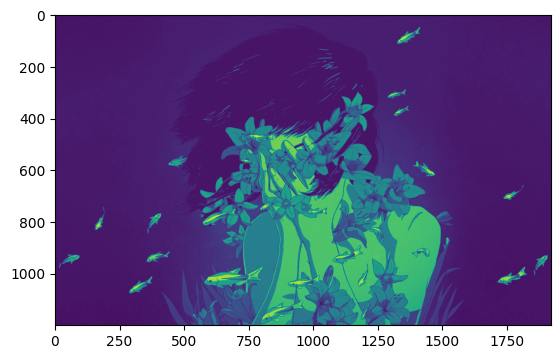

In [ ]:
sudo apt-get --purge remove "*nvidia*"
sudo apt-get autoremove
sudo apt install nvidia-driver-460

SyntaxError: ignored